## CPI and BER Data Analysis

The goal of this project is to analyze and build a model to predict the CPI, Consumer Price Index using the BER, Break Even Rate (the difference in yield between a fixed rate and inflation adjusted 10 year treasury note) data for the last decade. I will model and predict the CPI with and without the BER as an external regressor.

In [185]:
#import libraries

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import ccf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
#import CPI data and convert to datetime

cpi_df = pd.read_csv('CPI.csv')
cpi_df['date']= pd.to_datetime(cpi_df['date'])

In [4]:
#import BER data

ber_df = pd.read_csv('T10YIE.csv')

### I will use monthly data for CPI

In [6]:
# extract CPI for one value each month , choose the 24th

cpi_df2 = cpi_df.loc[cpi_df['date'].dt.strftime('%d') == "24"]
cpi_df2=cpi_df2.reset_index()
print(cpi_df2)

     index       date        CPI
0        0 2008-07-24  100.00000
1       31 2008-08-24  100.52510
2       62 2008-09-24  100.12380
3       92 2008-10-24   99.98538
4      123 2008-11-24   98.97539
..     ...        ...        ...
131   3987 2019-06-24  117.03590
132   4017 2019-07-24  117.05920
133   4048 2019-08-24  117.25480
134   4079 2019-09-24  117.24880
135   4109 2019-10-24        NaN

[136 rows x 3 columns]


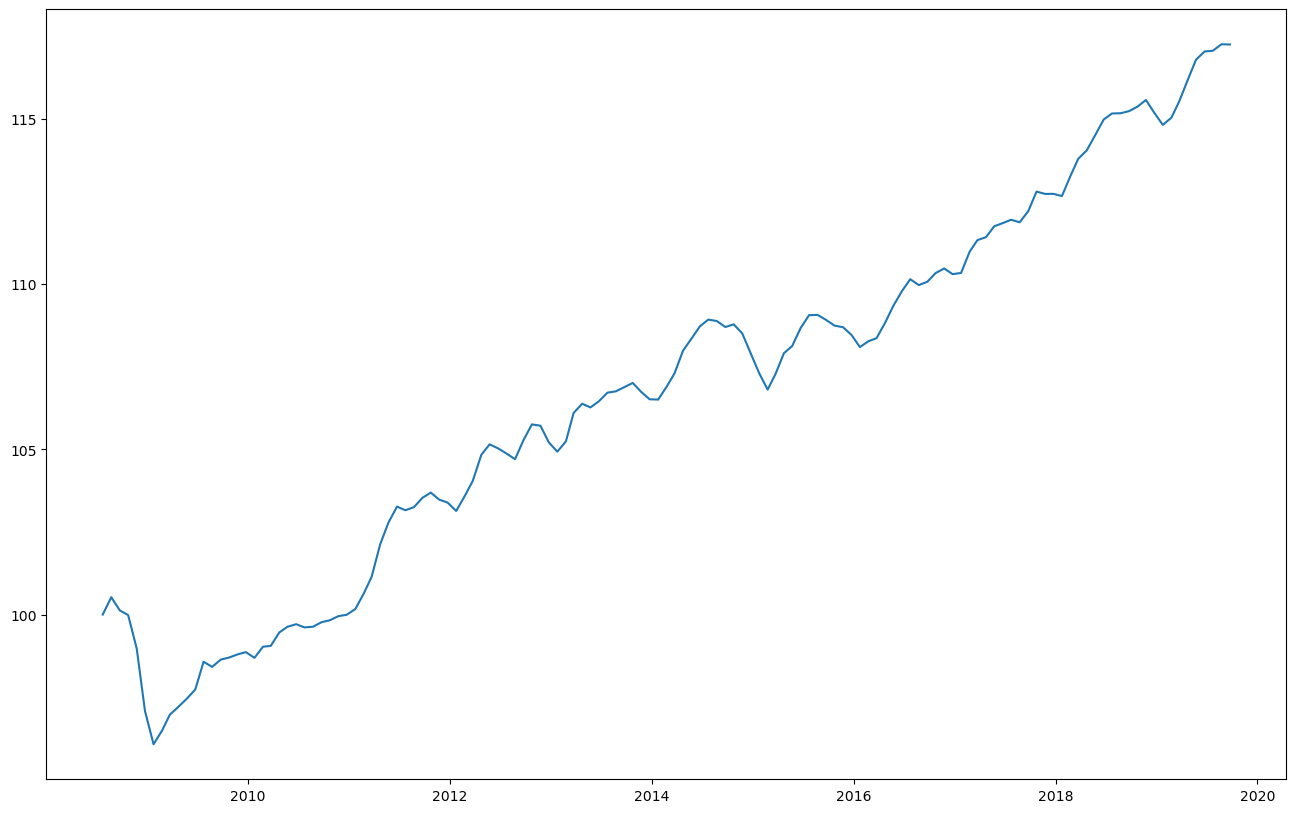

In [7]:
# plot the CPI 

fig, ax = plt.subplots(figsize=(16, 10))
plt.plot(cpi_df2.date, cpi_df2.CPI)
plt.show()

### Lets train a linear model to find the CPI trend related to the month index 

In [9]:
# Transform data to training, train on everything before September 2013, month 63
cpi_df2.loc[:,'months']=range(1,cpi_df2.shape[0]+1)
train_df = cpi_df2[cpi_df2['months'] < 63][:]
print(train_df)

    index       date        CPI  months
0       0 2008-07-24  100.00000       1
1      31 2008-08-24  100.52510       2
2      62 2008-09-24  100.12380       3
3      92 2008-10-24   99.98538       4
4     123 2008-11-24   98.97539       5
..    ...        ...        ...     ...
57   1735 2013-04-24  106.37890      58
58   1765 2013-05-24  106.26830      59
59   1796 2013-06-24  106.45750      60
60   1826 2013-07-24  106.71300      61
61   1857 2013-08-24  106.75510      62

[62 rows x 4 columns]


In [10]:
# fit linear model and find parameters 

X = np.array(train_df.months).reshape(-1, 1)
y = np.array(train_df.CPI).reshape(-1, 1)

reg= LinearRegression()
reg.fit(X,y)
print(reg.coef_, reg.intercept_)


[[0.16104348]] [96.56828285]


In [11]:
# Subtract the linear trend from the data to get the residuals

train_df.loc[:,"linear"]= np.array(reg.predict(X)).reshape(-1)
train_df.loc[:,'resid']= train_df.loc[:,"CPI"].to_numpy() - np.array(reg.predict(X)).reshape(-1)
print(train_df)

    index       date        CPI  months      linear     resid
0       0 2008-07-24  100.00000       1   96.729326  3.270674
1      31 2008-08-24  100.52510       2   96.890370  3.634730
2      62 2008-09-24  100.12380       3   97.051413  3.072387
3      92 2008-10-24   99.98538       4   97.212457  2.772923
4     123 2008-11-24   98.97539       5   97.373500  1.601890
..    ...        ...        ...     ...         ...       ...
57   1735 2013-04-24  106.37890      58  105.908805  0.470095
58   1765 2013-05-24  106.26830      59  106.069848  0.198452
59   1796 2013-06-24  106.45750      60  106.230892  0.226608
60   1826 2013-07-24  106.71300      61  106.391935  0.321065
61   1857 2013-08-24  106.75510      62  106.552979  0.202121

[62 rows x 6 columns]


### Lets plot the residuals

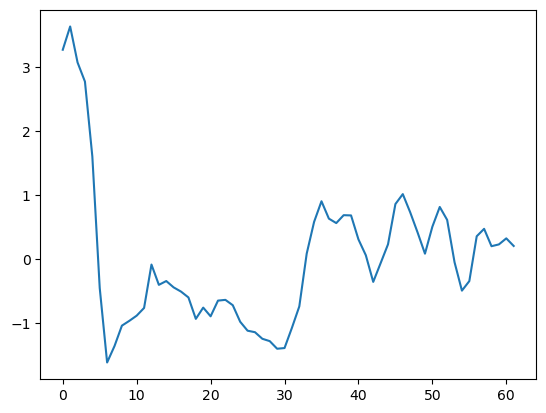

3.63473018760547


In [13]:
# plot the residuals

plt.plot(train_df['resid'])
plt.show()
print(train_df['resid'].max())

### Lets now use the residuals to find the p value (lag) of autoregressive model that will fit

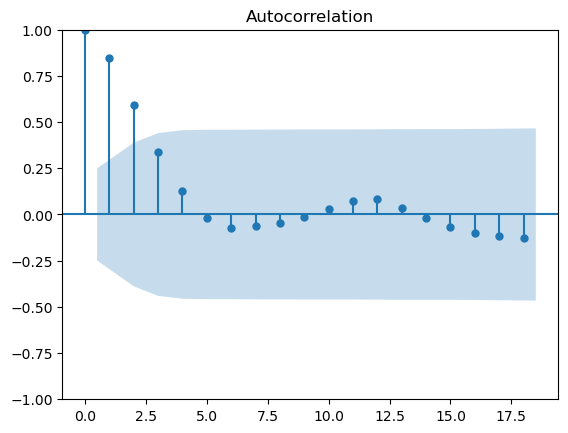

In [15]:
# now lets look at autocorrelation of the residuals to find the p value for a Autoregressive model

sm.graphics.tsa.plot_acf(train_df['resid'])
plt.show()

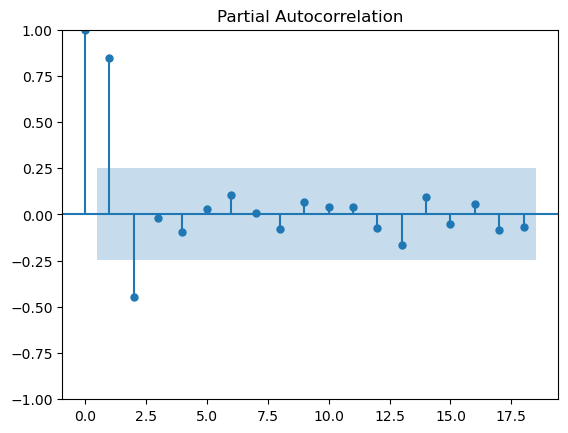

In [16]:
# lets plot the partial autocorrelation too 

sm.graphics.tsa.plot_pacf(train_df['resid'],method='ywm')
plt.show()


### So we can see from the autocorrelation that the lag is 2. Now lets use that information to fit an Autoregressive model, using AutoReg from statsmodels

In [18]:
# fitting an autoregressive model

res = AutoReg(train_df['CPI'], lags = 2, trend ="ct").fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                   62
Model:                     AutoReg(2)   Log Likelihood                 -15.541
Method:               Conditional MLE   S.D. of innovations              0.314
Date:                Sat, 21 Dec 2024   AIC                             41.081
Time:                        18:00:28   BIC                             51.553
Sample:                             2   HQIC                            45.178
                                   62                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.4543      3.736      5.475      0.000      13.132      27.777
trend          0.0392      0.007      5.693      0.000       0.026       0.053
CPI.L1         1.2761      0.098     12.999      0.0

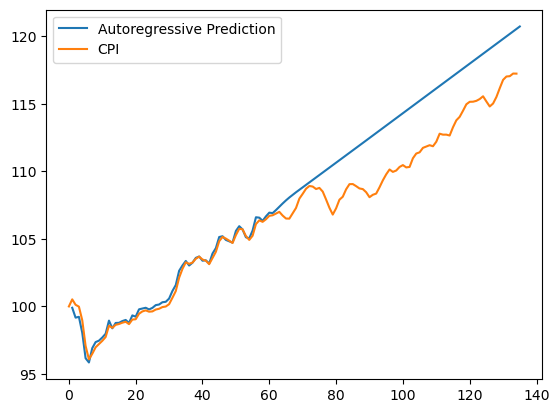

(136,)


In [19]:
# now lets plot our prediction versus our data

AR_pred =res.predict(start=1, end= 136).values
#Trend_pred =reg.predict(np.array(range(62,136)).reshape(-1,1))
#Trend_pred = Trend_pred.reshape(74,)

#fig = res.plot_predict(start=1, end= 136 )
fig = plt.plot(AR_pred, label = "Autoregressive Prediction")
fig = plt.plot(cpi_df2['CPI'], label = "CPI")
plt.legend()
plt.show()

cpi = cpi_df2['CPI'].dropna().values
AR_pred = AR_pred[np.logical_not(np.isnan(AR_pred))]
print(cpi_df2['CPI'].shape)

In [20]:
# now let build a model with detrended data

res2 = AutoReg(train_df['resid'], lags = 2 ).fit()
print(res2.summary())

                            AutoReg Model Results                             
Dep. Variable:                  resid   No. Observations:                   62
Model:                     AutoReg(2)   Log Likelihood                 -17.470
Method:               Conditional MLE   S.D. of innovations              0.324
Date:                Sat, 21 Dec 2024   AIC                             42.939
Time:                        18:00:28   BIC                             51.317
Sample:                             2   HQIC                            46.216
                                   62                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0431      0.042     -1.024      0.306      -0.126       0.039
resid.L1       1.3237      0.098     13.461      0.000       1.131       1.516
resid.L2      -0.5308      0.091     -5.824      0.0

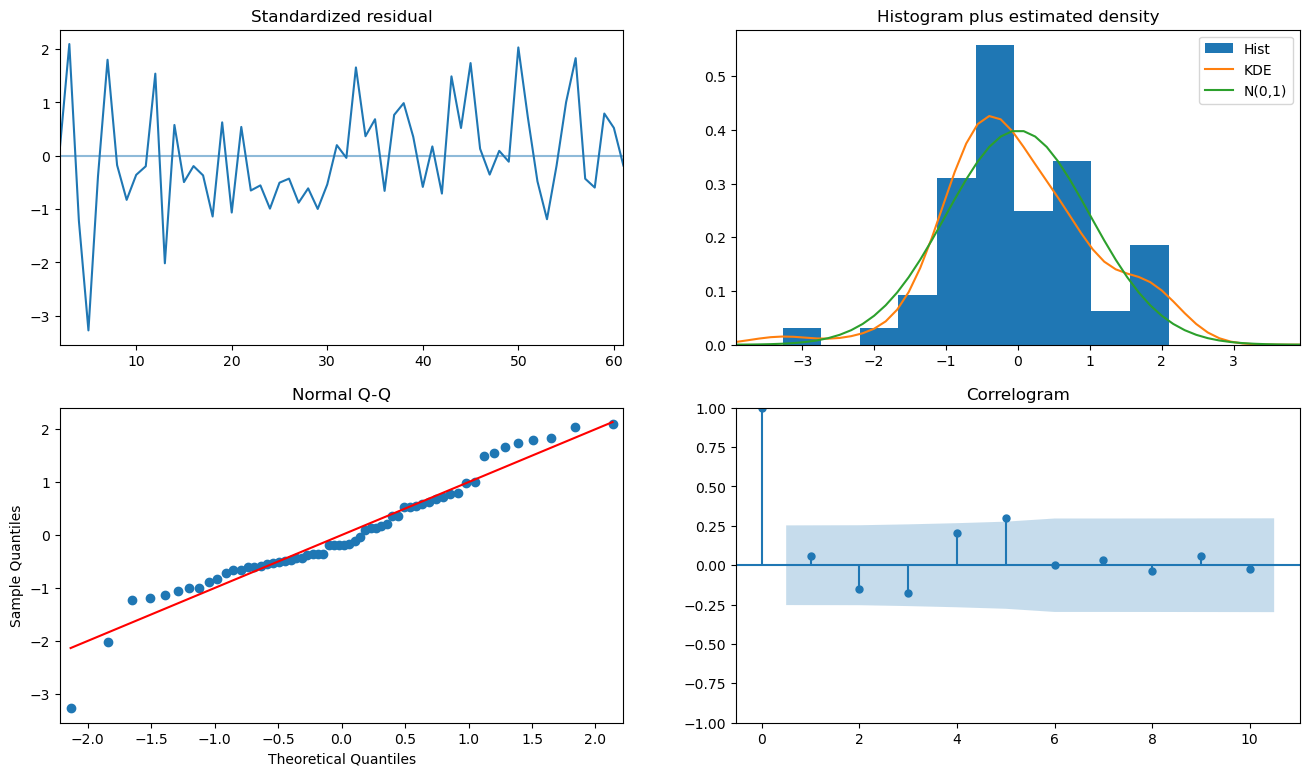

In [21]:
fig = plt.figure(figsize=(16, 9))
fig = res2.plot_diagnostics(fig=fig)

### Now lets start making predictions with the AR model.
We will make one day ahead predictions using the AR model parameters and the linear trend

In [23]:
# prepare the test set to predict on
test_df = cpi_df2[cpi_df2['months'] > 60][:]
X_test = np.array(test_df.months).reshape(-1, 1)

test_df.loc[:,"linear"]= np.array(reg.predict(X_test)).reshape(-1)
test_df['resid']= test_df["CPI"] - test_df["linear"]
test_df= test_df.dropna()

#iterate through predictive process, using the AR model and linear trend
constant=  -0.0431  
L1=  1.3237 
L2 = -0.5308 
l_list = []
for i in range(63,136):
    p2, p1 = test_df['resid'].iloc[i-63], test_df['resid'].iloc[i-62]
    p_new = L1*p1 + L2*p2 + constant + test_df['linear'][i-1]  
    l_list.append(p_new)

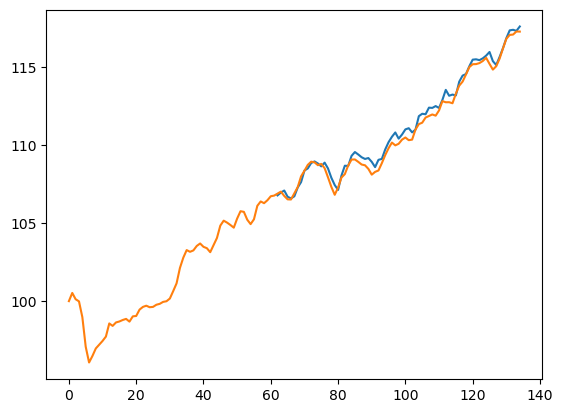

In [24]:
# lets plot the test model over the given data

fig = plt.plot(range(62,135),l_list)
fig = plt.plot(cpi_df2['CPI'])
plt.show()

In [25]:
predictions_df = cpi_df2['CPI'][cpi_df2['months'] > 62]
predictions_df= predictions_df.dropna()

In [26]:
#lets evaluate now with RMSE
print(mean_squared_error(predictions_df.values,l_list, squared = False))

0.39324026475655244


### Now lets calculate monthly inflation rates from the CPI data using the following formula:
$$
\text {IR}_ t = \frac{\text {CPI}_ t -\text {CPI}_{t-1}}{\text {CPI}_{t-1}}
$$

In [28]:
# get the data ready for the Inflation calculation, make numpy arrays for calculation
CPI_1= cpi_df2['CPI'].iloc[:-1].values
CPI_2= cpi_df2['CPI'].iloc[1:].values
CPI_1 = np.delete(CPI_1, 134)
CPI_2 = np.delete(CPI_2, 134)

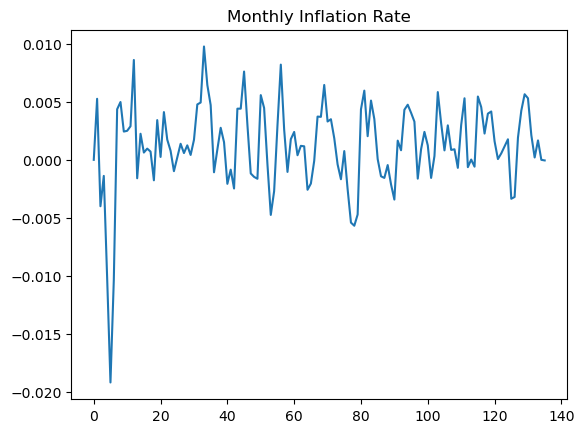

In [29]:
#calculate inflation rate, create a series, and add back to dataframe
Inflation_Rate = (CPI_2-CPI_1)/CPI_1
Inflation_Rate = np.insert(Inflation_Rate, (0, len(Inflation_Rate)-1),0)
plt.plot(Inflation_Rate)
plt.title("Monthly Inflation Rate")
plt.show()
cpi_df2["IR"]= Inflation_Rate

### Now lets try another equation for inflation: 
$$
\text {IR}_ t = \ln (\text {CPI}_ t) -\ln (\text {CPI}_{t-1})
$$

### Lets fit a linear model, using the second inflation rate calculation

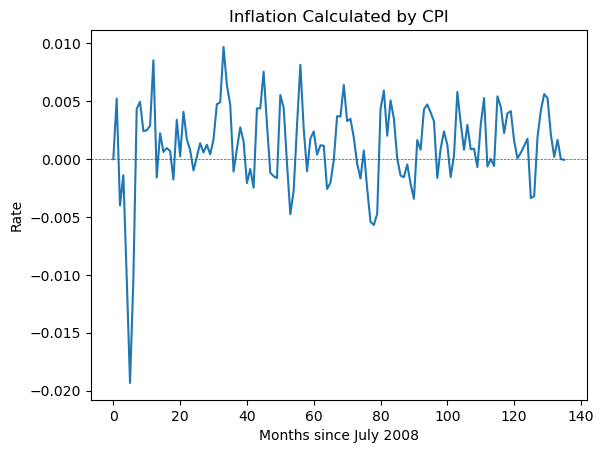

In [32]:
#use a different formulat for inflation
Inflation_Rate2 = np.log(CPI_2)-np.log(CPI_1)
Inflation_Rate2 = np.insert(Inflation_Rate2, (0, len(Inflation_Rate2)-1),0)
plt.plot(Inflation_Rate2)
plt.title("Inflation Calculated by CPI")
plt.ylabel("Rate")
plt.xlabel("Months since July 2008")
plt.axhline(y = 0, color = 'r', linewidth=.5,linestyle= "dashed")
plt.show()
cpi_df2["IR2"]= Inflation_Rate2

In [33]:
#train a linear model on inflation rate
future = int(len(Inflation_Rate2) * 0.8)

X = np.array(cpi_df2.months).reshape(-1, 1)
y = np.array(cpi_df2.IR2).reshape(-1, 1)

X_train, X_test, y_train, y_test = X[:future], X[future:], y[:future], y[future:]



reg= LinearRegression()
reg.fit(X_train,y_train)
print(reg.coef_, reg.intercept_)

cpi_df2["Trend"] = reg.predict(X)



[[1.18117769e-05]] [0.00039275]


### Lets see how the linear model looks

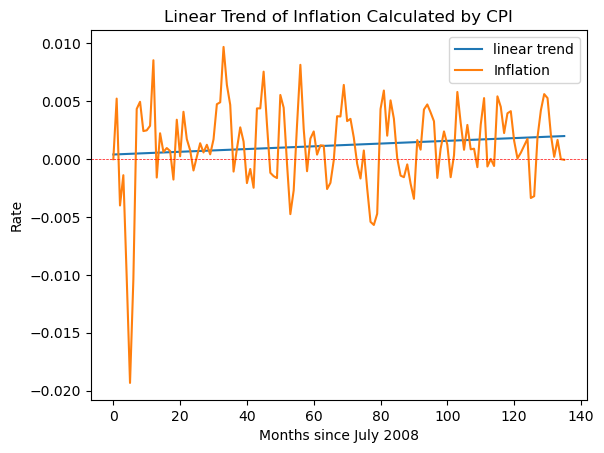

In [35]:
plt.plot(reg.predict(X), label= "linear trend")
plt.plot(Inflation_Rate2, label = "Inflation")
plt.title("Linear Trend of Inflation Calculated by CPI")
plt.ylabel("Rate")
plt.xlabel("Months since July 2008")
plt.axhline(y = 0, color = 'r', linewidth=.5,linestyle= "dashed")
plt.legend()

plt.show()

In [36]:
cpi_df2["Detrended_IR"]= cpi_df2.IR2- cpi_df2.Trend

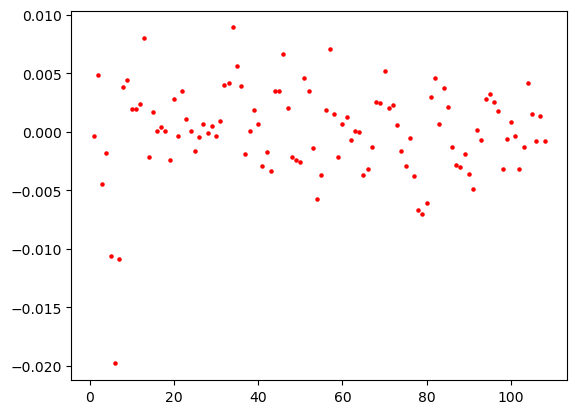

In [39]:
# And visualize the residuals

plt.scatter( X_train, y_train - reg.predict(X_train), s = 5 , color="red")
plt.show()

### Lets try a quadratic model

In [46]:
# lets try a quadratic model

cpi_df2["month_squared"] = np.power(np.array(cpi_df2.months),2)

X2 = np.append(X, np.array(cpi_df2.month_squared).reshape(-1, 1), axis = 1)


X2_train, X2_test, y2_train, y2_test = X2[:future], X2[future:], y[:future], y[future:]



reg2= LinearRegression()
reg2.fit(X2_train,y_train)
print(reg2.coef_, reg2.intercept_)

cpi_df2["Trend_2"] = reg2.predict(X2)

[[ 8.29780773e-05 -6.52901838e-07]] [-0.00091197]


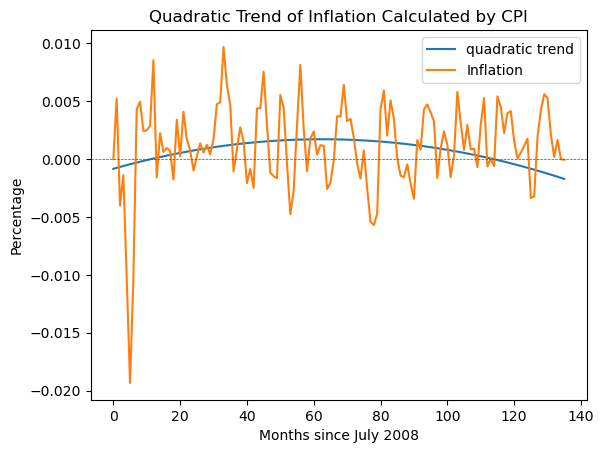

In [51]:
plt.plot(reg2.predict(X2), label= "quadratic trend")
plt.plot(Inflation_Rate2, label = "Inflation")
plt.title("Quadratic Trend of Inflation Calculated by CPI")
plt.ylabel("Percentage")
plt.xlabel("Months since July 2008")
plt.axhline(y = 0, color = 'r', linewidth=.5,linestyle= "dashed")
plt.legend()

plt.show()

### Now a cubic model

In [55]:
#lets try a cubic model

cpi_df2["month_cubed"] = np.power(np.array(cpi_df2.months),3)

X3 = np.append(X2, np.array(cpi_df2.month_cubed).reshape(-1, 1), axis = 1)


X3_train, X3_test, y_train, y_test = X3[:future], X3[future:], y[:future], y[future:]



reg3= LinearRegression()
reg3.fit(X3_train,y_train)
print(reg3.coef_, reg3.intercept_)

cpi_df2["Trend_3"] = reg3.predict(X3)

[[ 3.77924537e-04 -7.38665122e-06  4.11850115e-08]] [-0.0036526]


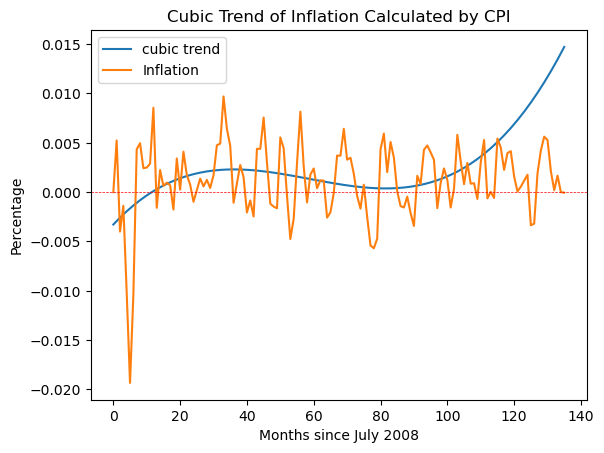

In [56]:
plt.plot(reg3.predict(X3), label= "cubic trend")
plt.plot(Inflation_Rate2, label = "Inflation")
plt.title("Cubic Trend of Inflation Calculated by CPI")
plt.ylabel("Percentage")
plt.xlabel("Months since July 2008")
plt.axhline(y = 0, color = 'r', linewidth=.5,linestyle= "dashed")
plt.legend()

plt.show()

### Lets use the linear fit

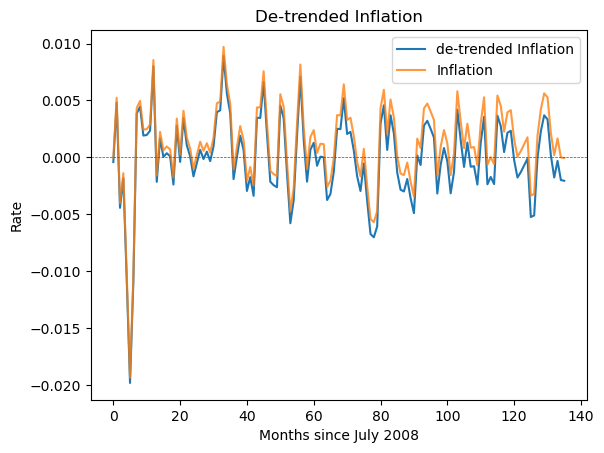

In [62]:
plt.plot(cpi_df2["Detrended_IR"], label= "de-trended Inflation")
plt.plot(Inflation_Rate2, label = "Inflation", alpha=0.8)
plt.title("De-trended Inflation")
plt.ylabel("Rate")
plt.xlabel("Months since July 2008")
plt.axhline(y = 0, color = 'r', linewidth=.5,linestyle= "dashed")
plt.legend()

plt.show()


### Is our detrended data stationary or do we need to add an AR component?
use the ADfuller test

In [64]:
#lets use the ADfuller test to find out if our data is stationary?
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(cpi_df2["Detrended_IR"], autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)
    
# a p value of less than .05 means that it is stationary

1. ADF :  -2.9383803248573575
2. P-Value :  0.04106347383714598
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 124
5. Critical Values :
	 1% :  -3.484219653271961
	 5% :  -2.885145235641637
	 10% :  -2.579359138917794


### Using a linear trend lets find the correct AR model to fit the data

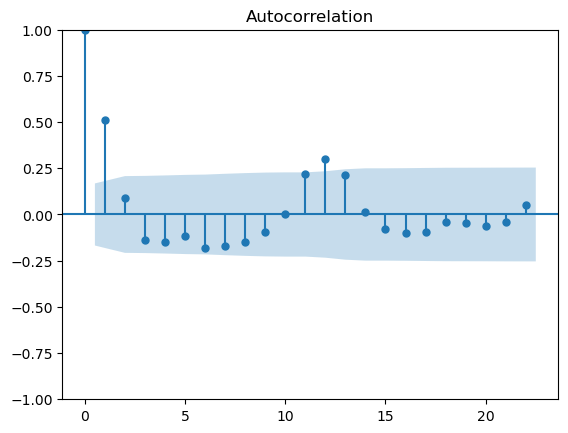

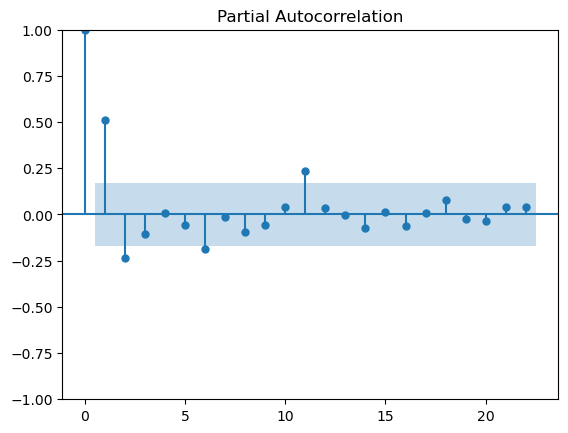

In [66]:
# now lets find an AR model to fit the detrended data

#lets plot the autoregressive and partial autoregressive models to find the p
sm.graphics.tsa.plot_acf(cpi_df2["Detrended_IR"])
plt.show()

sm.graphics.tsa.plot_pacf(cpi_df2["Detrended_IR"],method='ywm')
plt.show()

### From the visualations I will choose AR lag 1, lets build a model on the detrended data

In [70]:
# let start building an AR model with the lag 1

X = np.array(cpi_df2["Detrended_IR"]).reshape(-1, 1)

X_train, X_test, y_train, y_test = X[:future], X[future:], y[:future], y[future:]

reg = AutoReg(X_train, lags = 1 ).fit()
print(reg.summary())


                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  108
Model:                     AutoReg(1)   Log Likelihood                 457.814
Method:               Conditional MLE   S.D. of innovations              0.003
Date:                Sat, 21 Dec 2024   AIC                           -909.628
Time:                        18:00:36   BIC                           -901.609
Sample:                             1   HQIC                          -906.377
                                  108                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.027e-07      0.000     -0.001      1.000      -0.001       0.001
y.L1           0.5235      0.082      6.355      0.000       0.362       0.685
                                    Roots           

### Creating some functions to manually calculate the AIC and BIC for model selection with lags 1 - 14

[-255.65552726936278, -253.9046865318818, -251.7581770588805, -249.83424582428233, -247.6052607991466, -245.23798875984454, -242.66572699393453, -241.87249444908105, -240.6626484426809, -238.66365515333666, -239.6976880668501, -238.16263326822383, -236.29515358453313]
[-254.32332275918756, -251.2402775115314, -247.76156352835488, -244.50542778358152, -240.94423824827058, -237.24476169879333, -233.3402954227081, -231.21485836767943, -228.67280785110407, -225.3416100515846, -225.04343845492286, -222.1761791461214, -218.97649495225548]


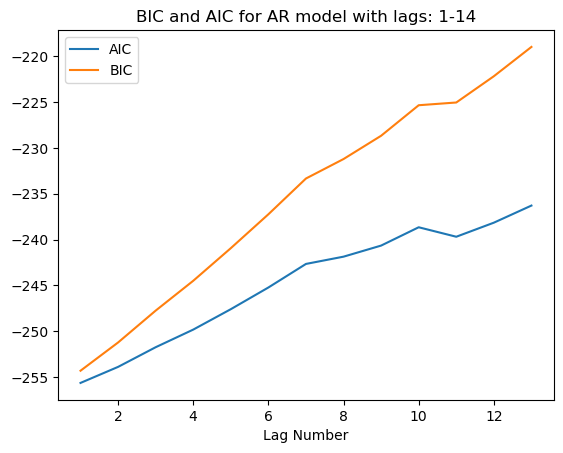

In [76]:
# Example here about how to find AIC and BIC
from scipy.stats import norm 
def evaluate_AIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and 
  the residuals of the model. Assumes residuals are distributed 
  Gaussian with unknown variance. 
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
  return 2 * k - 2 * np.sum(log_likelihood)
def evaluate_BIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and 
  the residuals of the model. Assumes residuals are distributed 
  Gaussian with unknown variance. 
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
  return k * np.log(len(residuals)) - 2 * np.sum(log_likelihood)

AIC_list = list()
BIC_list = list()
for i in range(1, 14):
    reg = AutoReg(X_train, lags = i).fit()
    pred = reg.predict(future, 135)
    residuals = cpi_df2["Detrended_IR"][future:]- pred
    AIC_list.append(evaluate_AIC(i,residuals))
    BIC_list.append(evaluate_BIC(i,residuals))

print(AIC_list)
print(BIC_list)

plt.plot(range(1, 14), AIC_list, label= "AIC")
plt.plot(range(1, 14), BIC_list, label = "BIC")
plt.xlabel("Lag Number")
plt.title("BIC and AIC for AR model with lags: 1-14")
plt.legend()
plt.show()

### My choice of using lag one looks correct, as the AIC and BIC are lowest there. 
### Now lets predict on the test set with the models with lag 1,2, 3 and see how they compare

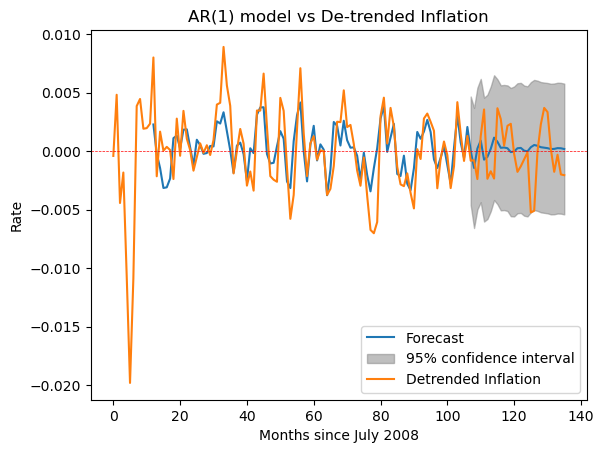

In [79]:
fig = reg.plot_predict(1, 136)
plt.plot(cpi_df2["Detrended_IR"], label ="Detrended Inflation")
plt.title("AR(1) model vs De-trended Inflation")
plt.ylabel("Rate")
plt.xlabel("Months since July 2008")
plt.axhline(y = 0, color = 'r', linewidth=.5,linestyle= "dashed")
plt.legend()
plt.show()

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  108
Model:                     AutoReg(2)   Log Likelihood                 456.965
Method:               Conditional MLE   S.D. of innovations              0.003
Date:                Sat, 21 Dec 2024   AIC                           -905.930
Time:                        18:00:37   BIC                           -895.276
Sample:                             2   HQIC                          -901.612
                                  108                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.009e-05      0.000     -0.159      0.874      -0.001       0.001
y.L1           0.6424      0.094      6.857      0.000       0.459       0.826
y.L2          -0.2243      0.094     -2.393      0.0

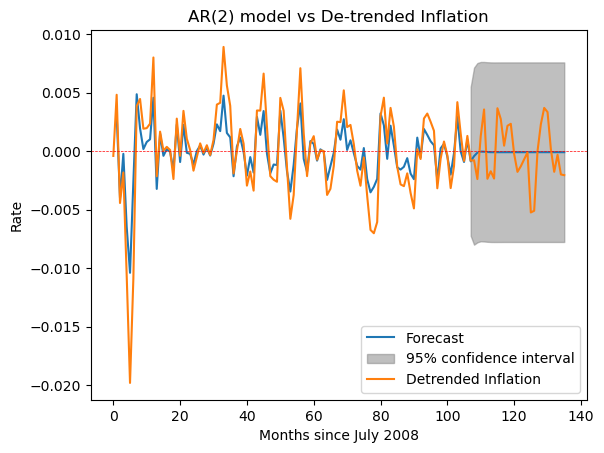

In [80]:
reg2 = AutoReg(X_train, lags = 2).fit()
print(reg2.summary())
               
fig = reg2.plot_predict(1, 136)
plt.plot(cpi_df2["Detrended_IR"],label ="Detrended Inflation")
plt.title("AR(2) model vs De-trended Inflation")
plt.ylabel("Rate")
plt.xlabel("Months since July 2008")
plt.axhline(y = 0, color = 'r', linewidth=.5,linestyle= "dashed")
plt.legend()
plt.show()

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  108
Model:                     AutoReg(3)   Log Likelihood                 455.642
Method:               Conditional MLE   S.D. of innovations              0.003
Date:                Sat, 21 Dec 2024   AIC                           -901.285
Time:                        18:00:38   BIC                           -888.015
Sample:                             3   HQIC                          -895.908
                                  108                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.263e-05      0.000      0.073      0.941      -0.001       0.001
y.L1           0.6505      0.095      6.881      0.000       0.465       0.836
y.L2          -0.1747      0.110     -1.593      0.1

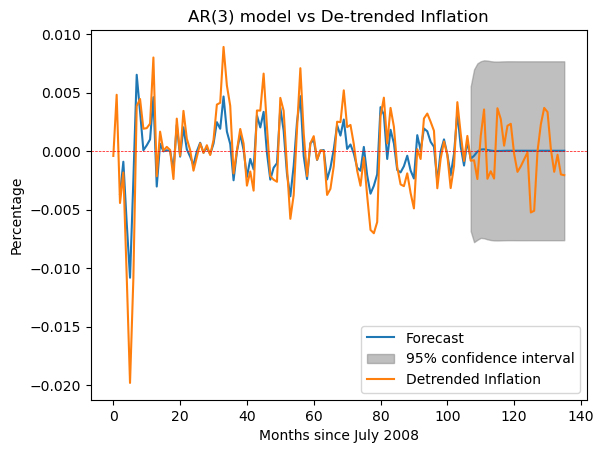

In [83]:
reg3 = AutoReg(X_train, lags = 3).fit()
print(reg3.summary())
               
fig = reg3.plot_predict(1, 136)
plt.plot(cpi_df2["Detrended_IR"],label ="Detrended Inflation")
plt.title("AR(3) model vs De-trended Inflation")
plt.ylabel("Percentage")
plt.xlabel("Months since July 2008")
plt.axhline(y = 0, color = 'r', linewidth=.5,linestyle= "dashed")
plt.legend()
plt.show()

<bound method AutoRegResults.summary of <statsmodels.tsa.ar_model.AutoRegResults object at 0x7f86e93f7820>>


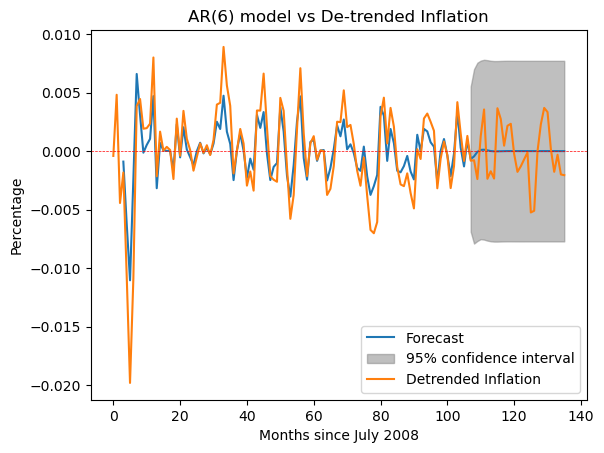

In [84]:
reg4 = AutoReg(X_train, lags = 4).fit()
print(reg4.summary)
               
fig = reg4.plot_predict(1, 136)
plt.plot(cpi_df2["Detrended_IR"],label ="Detrended Inflation")
plt.title("AR(6) model vs De-trended Inflation")
plt.ylabel("Percentage")
plt.xlabel("Months since July 2008")
plt.axhline(y = 0, color = 'r', linewidth=.5,linestyle= "dashed")
plt.legend()
plt.show()

In [89]:
print('AR(2) MSE:', mean_squared_error(cpi_df2["Detrended_IR"][5:], reg2.predict(6,136), squared = False))
print('AR(2) MAPE:', mean_absolute_percentage_error(cpi_df2["Detrended_IR"][5:], reg2.predict(6,136)))

print('AR(3) MSE:', mean_squared_error(cpi_df2["Detrended_IR"][5:], reg3.predict(6,136), squared = False))
print('AR(3) MAPE:', mean_absolute_percentage_error(cpi_df2["Detrended_IR"][5:], reg3.predict(6,136)))

print('AR(4) MSE:', mean_squared_error(cpi_df2["Detrended_IR"][5:], reg4.predict(6,136), squared = False))
print('AR(4) MAPE:', mean_absolute_percentage_error(cpi_df2["Detrended_IR"][5:], reg4.predict(6,136)))

AR(2) MSE: 0.0020986811385663067
AR(2) MAPE: 10.560339605978198
AR(3) MSE: 0.0020759729623500245
AR(3) MAPE: 4.805666091171894
AR(4) MSE: 0.002072365507678351
AR(4) MAPE: 1.5432249883879905


### Now lets start making predictions with the parameters from the AR model and linear trend

In [94]:
#now lets start making predictions with the AR model and trend:

constant=   -2.027e-07  
L1=   0.5235 
l_list = []
for i in range(future,136):
    p1 = cpi_df2["Detrended_IR"].iloc[i-1]
    p_new = L1*p1 + constant + cpi_df2['Trend'][i]  
    l_list.append(p_new)
    

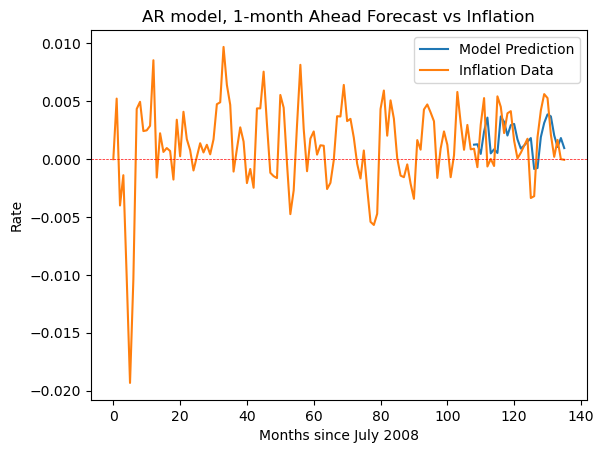

In [97]:
plt.plot(range(future, 136),l_list, label = "Model Prediction")
plt.plot(cpi_df2["IR2"],label ="Inflation Data")
plt.title("AR model, 1-month Ahead Forecast vs Inflation")
plt.ylabel("Rate")
plt.xlabel("Months since July 2008")
plt.axhline(y = 0, color = 'r', linewidth=.5,linestyle= "dashed")
plt.legend()
plt.show()


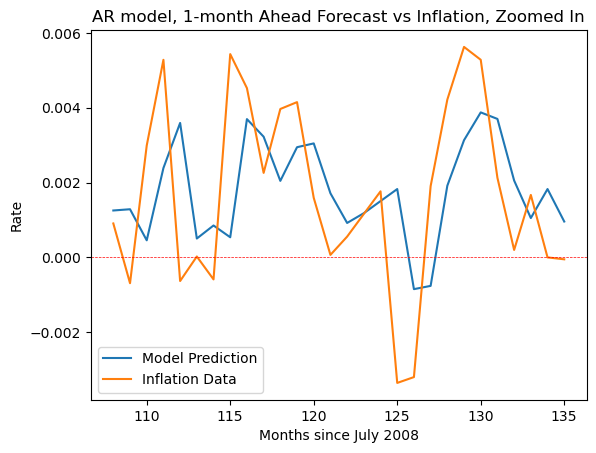

In [100]:
#lets zoom in
plt.plot(range(future, 136),l_list, label = "Model Prediction")
plt.plot(range(future, 136), cpi_df2["IR2"][future: 136],label ="Inflation Data")
plt.title("AR model, 1-month Ahead Forecast vs Inflation, Zoomed In")
plt.ylabel("Rate")
plt.xlabel("Months since July 2008")
plt.axhline(y = 0, color = 'r', linewidth=.5,linestyle= "dashed")
plt.legend()
plt.show()

In [106]:
#Now lets compare different lags with RMSE 
lag_RMSE= list()
for i in range(1,15):
    reg = reg = AutoReg(X_train, lags = i).fit()
    lag_RMSE.append(mean_squared_error(cpi_df2["Detrended_IR"][i-1:], reg.predict(i,136), squared = False))
    print("lag", i,"has RMSE:", mean_squared_error(cpi_df2["Detrended_IR"][i-1:], 
                                                   reg.predict(i,136), squared = False))

lag 1 has RMSE: 0.0019966004628383604
lag 2 has RMSE: 0.002107834700625227
lag 3 has RMSE: 0.0020919424291183293
lag 4 has RMSE: 0.0020939487011560703
lag 5 has RMSE: 0.0021575997796438305
lag 6 has RMSE: 0.0024375353091095693
lag 7 has RMSE: 0.002338134367021788
lag 8 has RMSE: 0.00205224225519286
lag 9 has RMSE: 0.0020852832823217283
lag 10 has RMSE: 0.00210052098597469
lag 11 has RMSE: 0.002227579247790339
lag 12 has RMSE: 0.0022392560522186598
lag 13 has RMSE: 0.002218582180153968
lag 14 has RMSE: 0.0021101580024313837


### We can see that lag 1 has the lowest RMSE, lets plot the RMSE of all lags

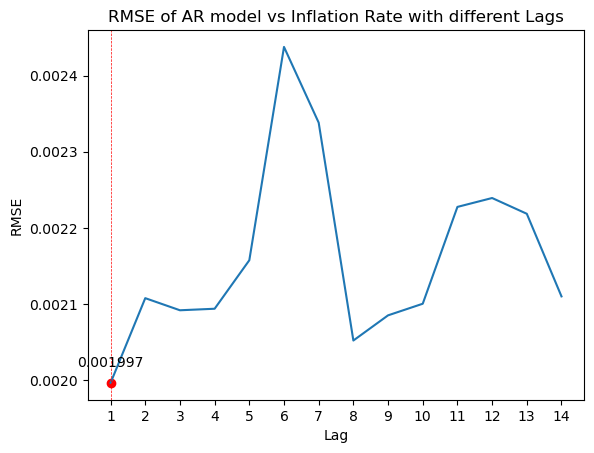

In [113]:
plt.plot(range(1,15),lag_RMSE)

plt.title("RMSE of AR model vs Inflation Rate with different Lags")
plt.ylabel("RMSE")
plt.xlabel("Lag")
plt.xticks(range(1,15))
plt.axvline(x=1, color = 'r', linewidth=.5,linestyle= "dashed")
plt.scatter(1, lag_RMSE[0], label = lag_RMSE[0], c= "r")
plt.annotate(round(lag_RMSE[0], 6), # this is the text
                 (1, round(lag_RMSE[0],3)), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') #

plt.show()

### Now we will import and clean and visualize the BER data

In [115]:
#import BER data 

ber_df = pd.read_csv('T10YIE.csv')
ber_df= ber_df.dropna()
ber_df['T10YIE'] = ber_df['T10YIE']/100

#extract BER for mean of each month
ber_df['DATE']= pd.to_datetime(ber_df['DATE'])
ber_df['year']= pd.DatetimeIndex(ber_df['DATE']).year

grouper= ber_df.groupby([pd.PeriodIndex(ber_df['DATE'], freq="M"), 'year'])['T10YIE'].mean()
ber_monthly_df =grouper.to_frame(name = "T10YIE").reset_index()

print(ber_monthly_df)

        DATE  year    T10YIE
0    2003-01  2003  0.017543
1    2003-02  2003  0.019126
2    2003-03  2003  0.018629
3    2003-04  2003  0.017748
4    2003-05  2003  0.016610
..       ...   ...       ...
198  2019-07  2019  0.017527
199  2019-08  2019  0.015864
200  2019-09  2019  0.015870
201  2019-10  2019  0.015609
202  2019-11  2019  0.016150

[203 rows x 3 columns]


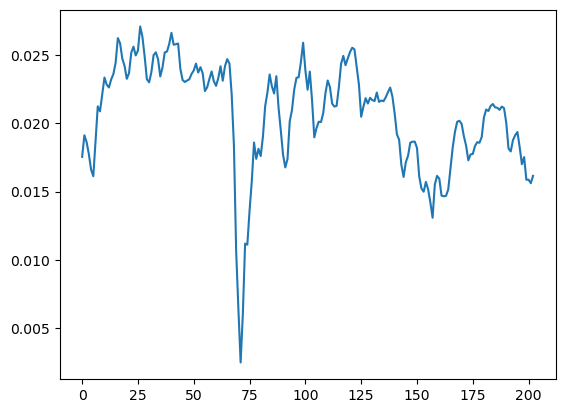

In [117]:
# plot monthly means
plt.plot( ber_monthly_df.T10YIE)
plt.show()

In [119]:
# now find the BER monthly

ber_monthly_df['monthyBER'] = ((ber_monthly_df.T10YIE + 1)**(1/12) -1)

print(ber_monthly_df)


        DATE  year    T10YIE  monthyBER
0    2003-01  2003  0.017543   0.001450
1    2003-02  2003  0.019126   0.001580
2    2003-03  2003  0.018629   0.001539
3    2003-04  2003  0.017748   0.001467
4    2003-05  2003  0.016610   0.001374
..       ...   ...       ...        ...
198  2019-07  2019  0.017527   0.001449
199  2019-08  2019  0.015864   0.001312
200  2019-09  2019  0.015870   0.001313
201  2019-10  2019  0.015609   0.001292
202  2019-11  2019  0.016150   0.001336

[203 rows x 4 columns]


In [121]:
print(ber_monthly_df[ber_monthly_df['DATE'] == '2013-2'])
ber_post2013 = ber_monthly_df[ber_monthly_df['DATE'] > '2008-6']
print(ber_post2013)
print(cpi_df2["IR2"])

        DATE  year    T10YIE  monthyBER
121  2013-02  2013  0.025547   0.002104
        DATE  year    T10YIE  monthyBER
66   2008-07  2008  0.024386   0.002010
67   2008-08  2008  0.022095   0.001823
68   2008-09  2008  0.018362   0.001517
69   2008-10  2008  0.010618   0.000881
70   2008-11  2008  0.006383   0.000530
..       ...   ...       ...        ...
198  2019-07  2019  0.017527   0.001449
199  2019-08  2019  0.015864   0.001312
200  2019-09  2019  0.015870   0.001313
201  2019-10  2019  0.015609   0.001292
202  2019-11  2019  0.016150   0.001336

[137 rows x 4 columns]
0      0.000000
1      0.005237
2     -0.004000
3     -0.001383
4     -0.010153
         ...   
131    0.002126
132    0.000199
133    0.001670
134    0.000000
135   -0.000051
Name: IR2, Length: 136, dtype: float64


### Lets visualize the BER, CPI, and our current predictions

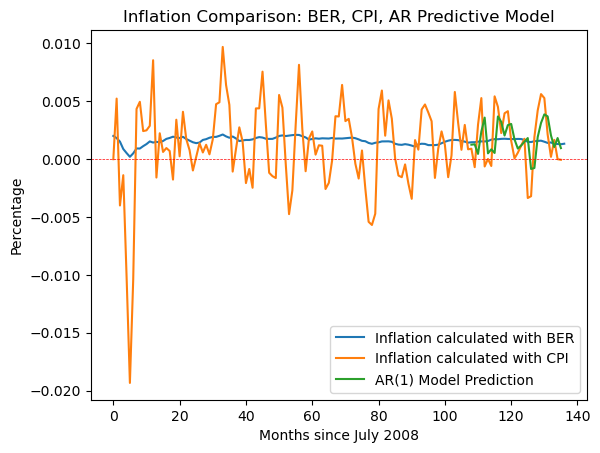

In [124]:
plt.plot(range(0, 137),ber_post2013['monthyBER'], label= "Inflation calculated with BER")
plt.plot(cpi_df2["IR2"], label ="Inflation calculated with CPI")
plt.plot(range(future, 136),l_list, label = "AR(1) Model Prediction")

plt.title("Inflation Comparison: BER, CPI, AR Predictive Model")
plt.ylabel("Percentage")
plt.xlabel("Months since July 2008")
plt.axhline(y = 0, color = 'r', linewidth=.5,linestyle= "dashed")
plt.legend()
plt.show()


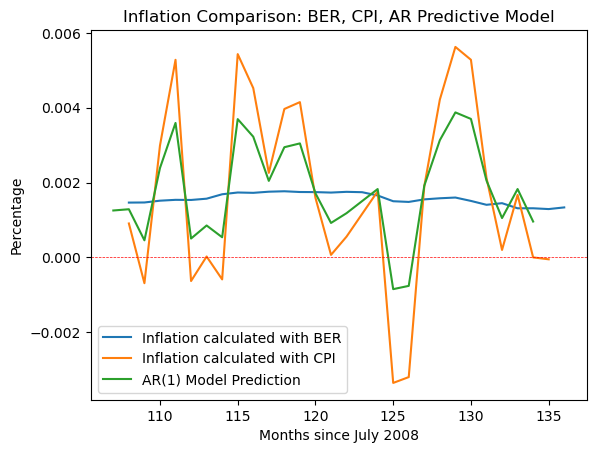

In [126]:
# zooming in

plt.plot(range(future, 137),ber_post2013['monthyBER'][future:], label= "Inflation calculated with BER")
plt.plot(cpi_df2["IR2"][future:], label ="Inflation calculated with CPI")
plt.plot(range(future-1, 135),l_list, label = "AR(1) Model Prediction")

plt.title("Inflation Comparison: BER, CPI, AR Predictive Model")
plt.ylabel("Percentage")
plt.xlabel("Months since July 2008")
plt.axhline(y = 0, color = 'r', linewidth=.5,linestyle= "dashed")
plt.legend()
plt.show()

### Lets see if BER is a good variable to regresss, using spearman and pearson correlation 

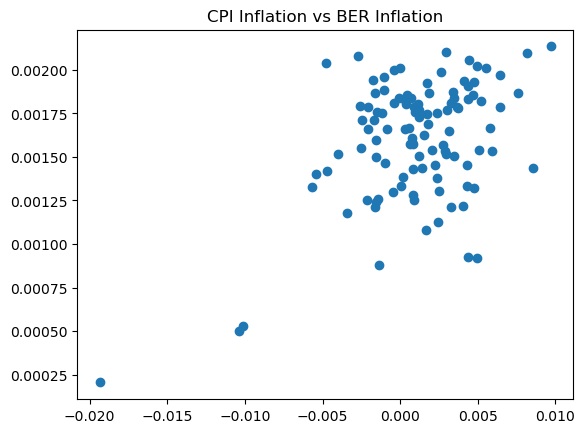

SignificanceResult(statistic=0.23527926700664778, pvalue=0.014239841968843809)


PearsonRResult(statistic=0.4812479904747541, pvalue=1.3476397739679793e-07)

In [129]:
#lets plot cross coorelation fxn between the BER vs the CPI to see if we can fit it as and external regressor

from scipy import stats
plt.scatter(cpi_df2["IR2"][:future], ber_post2013['monthyBER'][:future])
plt.title("CPI Inflation vs BER Inflation")
plt.show()
print(stats.spearmanr(cpi_df2["IR2"][:future],ber_post2013['monthyBER'][:future]))
stats.pearsonr(cpi_df2["IR2"][:future],ber_post2013['monthyBER'][:future])

### We see that the correlation is significant so we will try to find a good lag for cross correlation

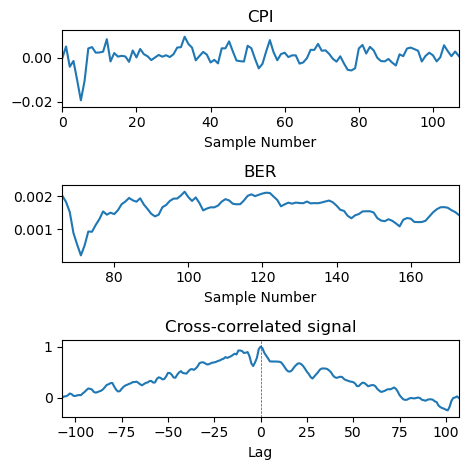

In [132]:
from scipy import signal

sig = cpi_df2["IR2"][:future]
sig_noise = ber_post2013['monthyBER'][:future]


corr = signal.correlate(sig_noise, sig)
lags = signal.correlation_lags(len(sig), len(sig_noise))
corr /= np.max(corr)

fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, figsize=(4.8, 4.8))
ax_orig.plot(sig)
ax_orig.set_title('CPI')
ax_orig.set_xlabel('Sample Number')
ax_noise.plot(sig_noise)
ax_noise.set_title('BER')
ax_noise.set_xlabel('Sample Number')
ax_corr.plot(lags, corr)
ax_corr.set_title('Cross-correlated signal')
ax_corr.axvline(x =0, color = 'r', linewidth=.5,linestyle= "dashed")
ax_corr.set_xlabel('Lag')
ax_orig.margins(0, 0.1)
ax_noise.margins(0, 0.1)
ax_corr.margins(0, 0.1)
fig.tight_layout()
plt.show()

### It looks like a lag of zero is optimal, Lets fit a new model for CPI inflation, using the BER as an external regressor with lag 0

In [135]:
print(len(cpi_df2))
print(len(ber_post2013[:future]))

136
108


In [137]:
print(len(corr))
print(corr.argmax())

215
107


In [139]:
ber = np.array(ber_post2013['monthyBER'][:future]).reshape(-1, 1)

sar = sm.tsa.statespace.SARIMAX(cpi_df2["IR2"][:future], ber,order= (1,0,0), trend= "t").fit() 
print(sar.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.29648D+00    |proj g|=  1.76005D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     16      1     0     0   1.759D+03  -4.296D+00
  F =  -4.2964776992884621     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


                               SARIMAX Results                                
Dep. Variable:                    IR2   No. Observations:                  108
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 464.020
Date:                Sat, 21 Dec 2024   AIC                           -920.039
Time:                        18:01:11   BIC                           -909.311
Sample:                             0   HQIC                          -915.689
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -8.633e-07   1.13e-05     -0.076      0.939   -2.31e-05    2.14e-05
x1             0.8606      0.757      1.136      0.256      -0.624       2.345
ar.L1          0.5061      0.059      8.600      0.0

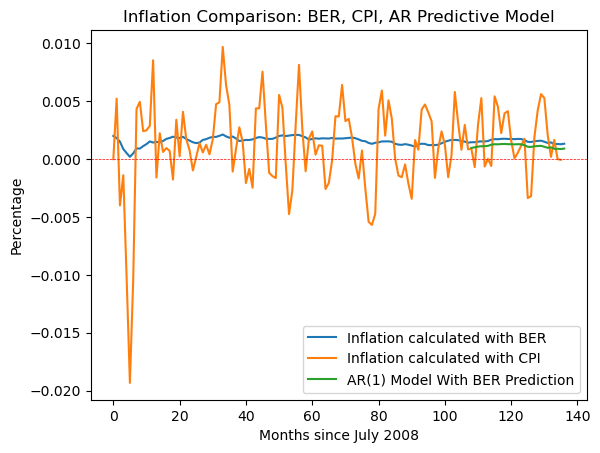

In [141]:
ber2 = np.array(ber_post2013['monthyBER'][future:]).reshape(-1, 1)
#predict = sar.predict(1, 136, exog=ber2 )
predict = sar.predict(start= future, end = 136, exog= ber2)


plt.plot(range(0, 137),ber_post2013['monthyBER'], label= "Inflation calculated with BER")
plt.plot(cpi_df2["IR2"], label ="Inflation calculated with CPI")
plt.plot(predict, label = "AR(1) Model With BER Prediction")

plt.title("Inflation Comparison: BER, CPI, AR Predictive Model")
plt.ylabel("Percentage")
plt.xlabel("Months since July 2008")
plt.axhline(y = 0, color = 'r', linewidth=.5,linestyle= "dashed")
plt.legend()
plt.show()

### Now lets use the AR1 model's parameters to make monthly predictions

In [144]:
drift=   -8.633e-07  
L1=   0.5061
x1 = 0.8606 
l_list2 = []
for i in range(future,136):
    p = cpi_df2["IR2"].iloc[i]
    p1 = cpi_df2["IR2"].iloc[i-1]
    y= ber_post2013['monthyBER'][i]
    p_new = L1*p1 + drift* i + y*x1  
    l_list2.append(p_new)
    

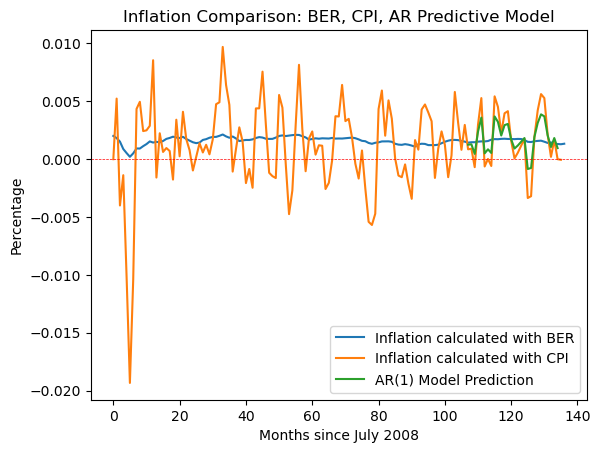

In [146]:
plt.plot(range(0, 137),ber_post2013['monthyBER'], label= "Inflation calculated with BER")
plt.plot(cpi_df2["IR2"], label ="Inflation calculated with CPI")
plt.plot(range(future-1, 135), l_list, label = "AR(1) Model Prediction")

plt.title("Inflation Comparison: BER, CPI, AR Predictive Model")
plt.ylabel("Percentage")
plt.xlabel("Months since July 2008")
plt.axhline(y = 0, color = 'r', linewidth=.5,linestyle= "dashed")
plt.legend()
plt.show()

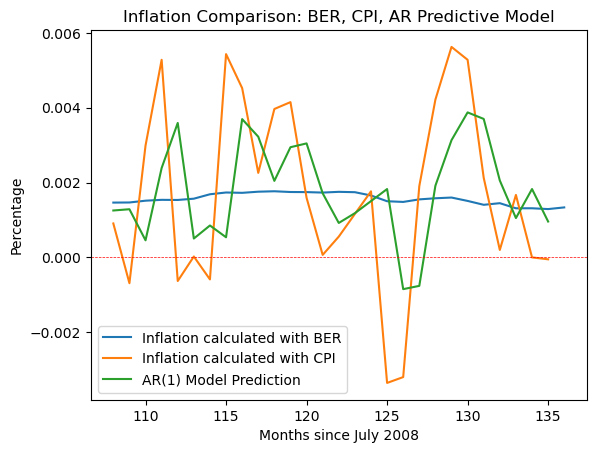

In [148]:
# zooming in

plt.plot(range(future, 137),ber_post2013['monthyBER'][future:], 
         label= "Inflation calculated with BER")
plt.plot(cpi_df2["IR2"][future:], label ="Inflation calculated with CPI")
plt.plot(range(future, 136),l_list, label = "AR(1) Model Prediction")
#plt.plot(range(future, 136),l_list2, label = "SARIMAX Model Prediction")
#plt.plot(range(future-1, 135),l_list3, label = "SARIMAX2 Model Prediction")

plt.title("Inflation Comparison: BER, CPI, AR Predictive Model")
plt.ylabel("Percentage")
plt.xlabel("Months since July 2008")
plt.axhline(y = 0, color = 'r', linewidth=.5,linestyle= "dashed")
plt.legend()
plt.show()

### Lets compare the MSE of the model with and without BER exogonous variable

In [151]:
print("MSE without BER:", mean_squared_error(cpi_df2["IR"][future:], l_list, squared = False))
print("MSE with BER:", mean_squared_error(cpi_df2["IR"][future:], l_list2, squared = False))

MSE without BER: 0.0022260457219064637
MSE with BER: 0.0023027259202181905


### Now lets try a sarimax model with out trend and add it back in

In [187]:


ber = np.array(ber_post2013['monthyBER'][:future]).reshape(-1)

sar_2 = sm.tsa.statespace.SARIMAX(cpi_df2["Detrended_IR"][:future], ber,order= (1,0,0),seasonal_order=(1,1,0,12)).fit() 
print(sar_2.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.81143D+00    |proj g|=  2.22523D+01
  ys=-4.150E-09  -gs= 2.673E-09 BFGS update SKIPPED

At iterate    5    f= -3.81310D+00    |proj g|=  3.72284D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     85      2     1     0   3.722D-01  -3.813D+00
  F =  -3.8131002858854348     

ABNORMAL_TERMINATION_IN_LNSRCH                              
                                     SARIMAX Results                                      
Dep. Variable:                       Detrended_IR   No. Observations:                  108
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                 411.815
Date:                            Sat, 21 Dec 2024   AIC                           -815.630
Time:                                    18:12:08   BIC    


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [189]:

L1=   0.5210 
x1 = 0.2434 
l_list3 = []
for i in range(future,136):
    p = cpi_df2["Detrended_IR"].iloc[i]
    p1 = cpi_df2["Detrended_IR"].iloc[i-1]
    y= ber_post2013['monthyBER'][i]
    p_new = L1*p1  + y*x1 + cpi_df2['Trend'][i]  
    l_list3.append(p_new)

In [158]:
print(cpi_df2)

     index       date        CPI  months        IR       IR2     Trend  \
0        0 2008-07-24  100.00000       1  0.000000  0.000000  0.000405   
1       31 2008-08-24  100.52510       2  0.005251  0.005237  0.000416   
2       62 2008-09-24  100.12380       3 -0.003992 -0.004000  0.000428   
3       92 2008-10-24   99.98538       4 -0.001382 -0.001383  0.000440   
4      123 2008-11-24   98.97539       5 -0.010101 -0.010153  0.000452   
..     ...        ...        ...     ...       ...       ...       ...   
131   3987 2019-06-24  117.03590     132  0.002129  0.002126  0.001952   
132   4017 2019-07-24  117.05920     133  0.000199  0.000199  0.001964   
133   4048 2019-08-24  117.25480     134  0.001671  0.001670  0.001976   
134   4079 2019-09-24  117.24880     135  0.000000  0.000000  0.001987   
135   4109 2019-10-24        NaN     136 -0.000051 -0.000051  0.001999   

     Detrended_IR  month_squared   Trend_2  month_cubed   Trend_3  
0       -0.000405              1 -0.000830 

### Evaluating the three models:

In [160]:
print("MSE without BER:", mean_squared_error(cpi_df2["IR"][future:], l_list, squared = False))
print("MSE with BER, AR1:", mean_squared_error(cpi_df2["IR"][future:], l_list2, squared = False))
print("MSE with BER, SARMAX:", mean_squared_error(cpi_df2["IR"][future:], l_list3, squared = False))

MSE without BER: 0.0022260457219064637
MSE with BER, AR1: 0.0023027259202181905
MSE with BER, SARMAX: 0.0022848613444821165


In [172]:
lists = [l_list, l_list2, l_list3]
params = [1,2,2]
label = ['without BER', 'MSE with BER, AR1', 'MSE with BER, SARMAX:']

for i, b, l in zip(lists, params, label):
    residuals = cpi_df2["IR"][future:]- i
    print("AIC " + l, evaluate_AIC(b,residuals))
    print("BIC " + l, evaluate_BIC(b,residuals))

AIC without BER -260.56099619176786
BIC without BER -259.22879168159267
AIC MSE with BER, AR1 -256.5424249039703
BIC MSE with BER, AR1 -253.8780158836199
AIC MSE with BER, SARMAX: -257.0507721349764
BIC MSE with BER, SARMAX: -254.386363114626


### Looking at signal decomposition

### Looking at seasonal decomposition

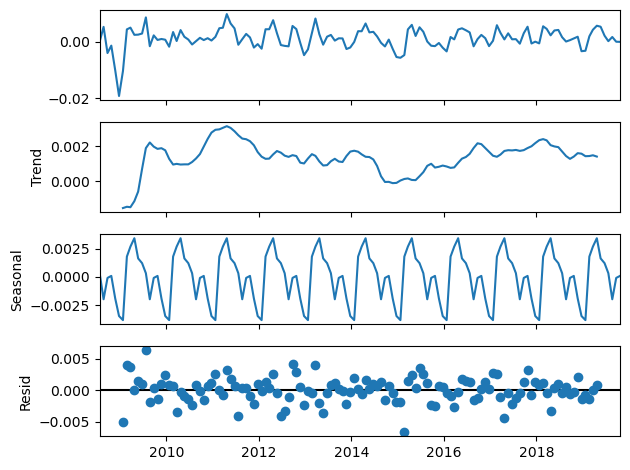

In [177]:
from statsmodels.tsa.seasonal import seasonal_decompose

test_cpi = cpi_df2[["IR", "date"]].copy()
test_cpi.index = pd.to_datetime(test_cpi['date'])
test_cpi.drop(columns='date',inplace=True)
test_cpi.head()

decompose_data = seasonal_decompose(test_cpi, model="additive", period = 12)
decompose_data.plot();

<Axes: xlabel='date'>

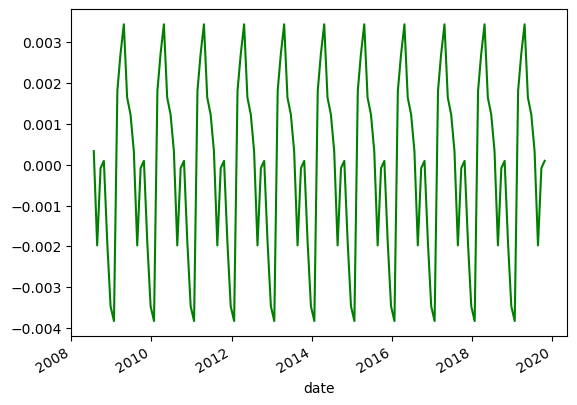

In [179]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

In [193]:
test_cpi.head()

,IR
date,
2008-07-24,0.000000
2008-08-24,0.005251
2008-09-24,-0.003992
2008-10-24,-0.001382
2008-11-24,-0.010101


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  108
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                 466.491
Date:                             Sat, 21 Dec 2024   AIC                           -920.982
Time:                                     18:13:55   BIC                           -904.889
Sample:                                          0   HQIC                          -914.456
                                             - 108                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -9.204e-07   1.39e-05     -0.066      0.947   -2.81e-05    2.63e-05
x1             0.8645      

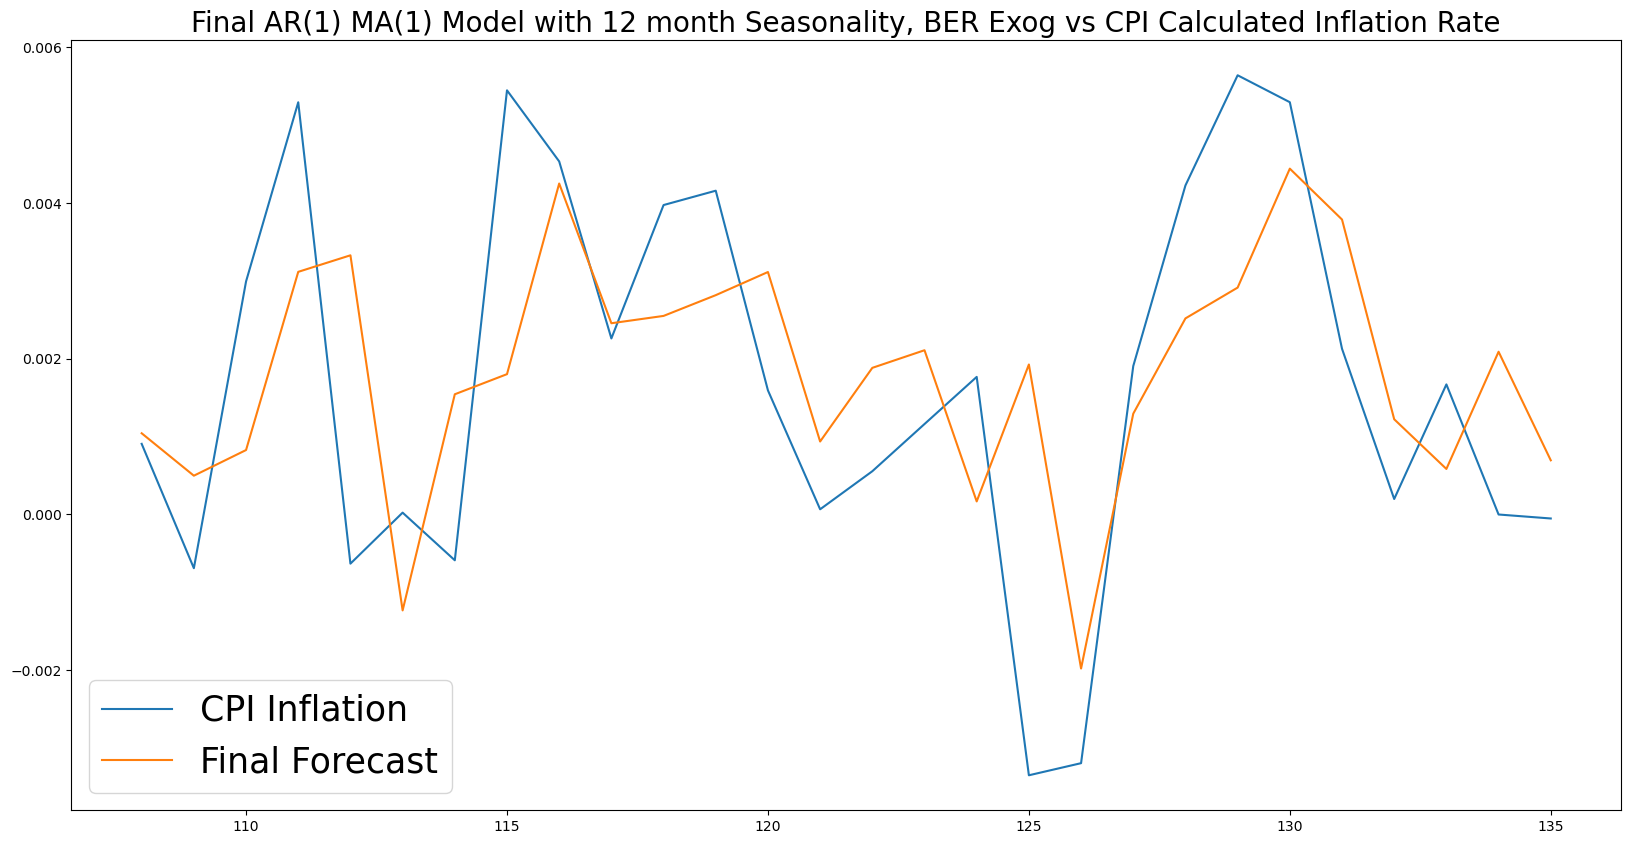

In [195]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 
import math


def rolling_forecast(train, test, order, season):
    history = [x for x in train]

    model = sm.tsa.statespace.SARIMAX(history,exog=ber[:future], order= order,trend='t', seasonal_order= season)
    model_fit = model.fit(disp=False)
    print(model_fit.summary())
    predictions = []
    results = {}
    print(model_fit.forecast(exog=ber_post2013['monthyBER'][future]))
    yhat = model_fit.forecast(exog=ber_post2013['monthyBER'][future])[0]

    predictions.append(yhat)
    history.append(test[0])
    for i in range(1, len(test)):
        model = sm.tsa.statespace.SARIMAX(history,exog=np.array(ber_post2013['monthyBER'][:future+i]).reshape(-1), order= order, trend='t',seasonal_order= season)
        model_fit = model.fit(disp=False)
        print(model_fit.forecast(exog=ber_post2013['monthyBER'][future+i +1]))
        yhat = model_fit.forecast(exog=ber_post2013['monthyBER'][future+i +1])[0]
        predictions.append(yhat)
        obs = test[i]
        history.append(obs)
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    rmse = math.sqrt(mse)
    predictions = pd.Series(predictions, index=range(future,136))
    results['predictions'] = predictions
    results['mse'] = mse
    results['rmse'] = rmse
    results['mae'] = mae
    return results

rolling_fcast = rolling_forecast(cpi_df2["IR"][:future],np.array(cpi_df2["IR"][future:]).reshape(-1), (1, 0, 1), (1, 0, 0, 12))

plt.figure(figsize=(20, 10))
plt.title('Final AR(1) MA(1) Model with 12 month Seasonality, BER Exog vs CPI Calculated Inflation Rate',fontsize=20)
plt.plot(cpi_df2["IR"][future:], label='CPI Inflation')
plt.plot(rolling_fcast['predictions'], label='Final Forecast')


print(f'Mean Squared Error: {rolling_fcast["mse"]}')
print(f'Root Mean Squared Error: {rolling_fcast["rmse"]}')
print(f'Mean Absolute Error: {rolling_fcast["mae"]}')
plt.legend(fontsize=25)
plt.show()

In [ ]:

rolling_fcast = rolling_forecast(cpi_df2["IR"][:future],np.array(cpi_df2["IR"][future:]).reshape(-1), (1, 0, 2), (1, 0, 0, 12))

plt.figure(figsize=(20, 10))
plt.title('AR(1), MA(1),12 Month Seasonality, BER', fontsize=30)
plt.plot(cpi_df2["IR"], label='CPI')
plt.plot(rolling_fcast['predictions'], label='Forecast')


print(f'Mean Squared Error: {rolling_fcast["mse"]}')
print(f'Root Mean Squared Error: {rolling_fcast["rmse"]}')
print(f'Mean Absolute Error: {rolling_fcast["mae"]}')
plt.legend(fontsize=25)
plt.show()

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  108
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 12)   Log Likelihood                 468.274
Date:                             Sat, 21 Dec 2024   AIC                           -922.549
Time:                                     18:21:36   BIC                           -903.774
Sample:                                          0   HQIC                          -914.936
                                             - 108                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -5.956e-06   1.94e-05     -0.307      0.759   -4.39e-05     3.2e-05
x1             0.8645      